In [1]:
# ==========================================
# Phase 2: Diabetic Retinopathy Prediction – APTOS CNN
# ==========================================

# 1️⃣ Import Libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [2]:
base_dir = r"C:\Users\vansh\OneDrive\Documents\diabetic_screening_project\data\aptos"

train_csv = os.path.join(base_dir, "train.csv")
valid_csv = os.path.join(base_dir, "valid.csv")
train_dir = os.path.join(base_dir, "train_images")
valid_dir = os.path.join(base_dir, "val_images")

In [3]:
# 3️⃣ Load Labels
train_df = pd.read_csv(train_csv)
valid_df = pd.read_csv(valid_csv)

print("Train samples:", len(train_df))
print("Validation samples:", len(valid_df))

train_df.head()


Train samples: 2930
Validation samples: 366


,id_code,diagnosis
0,1ae8c165fd53,2
1,1b329a127307,1
2,1b32e1d775ea,4
3,1b3647865779,0
4,1b398c0494d1,0


In [4]:
train_df['diagnosis'] = train_df['diagnosis'].astype(str)
valid_df['diagnosis'] = valid_df['diagnosis'].astype(str)


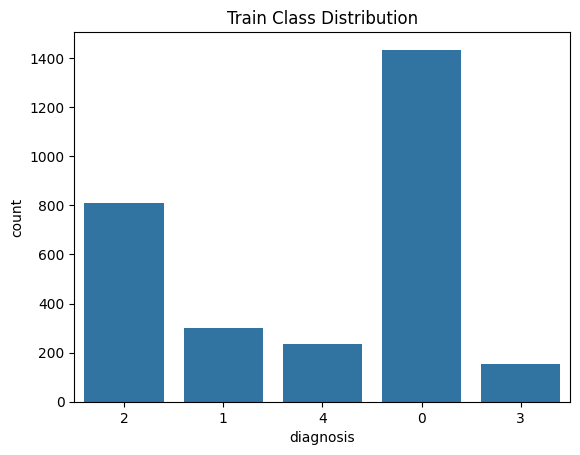

In [5]:
# 4️⃣ Check class distribution
sns.countplot(x='diagnosis', data=train_df)
plt.title("Train Class Distribution")
plt.show()


In [6]:
# ==============================
# Step 5: Image Preprocessing & Generators (CPU optimized)
# ==============================

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- Load CSVs ---
train_csv = r"C:\Users\vansh\OneDrive\Documents\diabetic_screening_project\data\aptos\train.csv"
valid_csv = r"C:\Users\vansh\OneDrive\Documents\diabetic_screening_project\data\aptos\valid.csv"

train_df = pd.read_csv(train_csv)
valid_df = pd.read_csv(valid_csv)

# --- Convert diagnosis to string ---
train_df['diagnosis'] = train_df['diagnosis'].astype(str)
valid_df['diagnosis'] = valid_df['diagnosis'].astype(str)

# --- Ensure filenames include extension ---
train_df['id_code'] = train_df['id_code'] + ".png"
valid_df['id_code'] = valid_df['id_code'] + ".png"

# --- Define smaller image size for CPU ---
IMG_SIZE = (224, 224)  # smaller than 300x300

# --- ImageDataGenerators (minimal augmentation) ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)

# --- Directories ---
train_dir = r"C:\Users\vansh\OneDrive\Documents\diabetic_screening_project\data\aptos\train_images"
valid_dir = r"C:\Users\vansh\OneDrive\Documents\diabetic_screening_project\data\aptos\val_images"

# --- Generators ---
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col='id_code',
    y_col='diagnosis',
    target_size=IMG_SIZE,
    batch_size=8,           # smaller batch for CPU
    class_mode='categorical',
    shuffle=True,
    color_mode='rgb'
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory=valid_dir,
    x_col='id_code',
    y_col='diagnosis',
    target_size=IMG_SIZE,
    batch_size=8,
    class_mode='categorical',
    shuffle=False,
    color_mode='rgb'
)


Found 2930 validated image filenames belonging to 5 classes.
Found 366 validated image filenames belonging to 5 classes.


In [7]:
# # ==============================
# # Step 6: Build EfficientNetB3 Model
# # ==============================

# from tensorflow.keras.applications import EfficientNetB3
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam

# # --- 1️⃣ Load EfficientNetB3 base model ---
# # ⚡ Use weights=None for now to avoid shape mismatch
# # ⚡ input_shape must be 3 channels (RGB)
# base_model = EfficientNetB3(
#     weights=None,          # don't use pretrained weights for now
#     include_top=False,     # remove default classifier
#     input_shape=(300, 300, 3)
# )

# # --- 2️⃣ Freeze the base layers initially (optional) ---
# # Prevent updating pretrained weights during initial training
# for layer in base_model.layers:
#     layer.trainable = True   # You can later set False if using pretrained

# # --- 3️⃣ Add custom top layers ---
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dropout(0.3)(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.2)(x)
# output = Dense(5, activation='softmax')(x)  # 5 classes for DR diagnosis

# # --- 4️⃣ Create final model ---
# model = Model(inputs=base_model.input, outputs=output)

# # --- 5️⃣ Compile model ---
# model.compile(
#     optimizer=Adam(learning_rate=0.0001),
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# # ✅ Model summary
# model.summary()



from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = EfficientNetB0(
    weights=None,
    include_top=False,
    input_shape=(224, 224, 3)
)

# Add top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 224, 224, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 224, 224, 3)       │               7 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 225, 225, 3)       │               0 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 112, 112, 32)      │             864 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 112, 112, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 112, 112, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 112, 112, 32)      │             288 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 112, 112, 32)      │             128 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 112, 112, 32)      │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 32)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 32)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 8)           │             264 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 32)          │             288 │ block1a_se_reduce[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_excite (Multiply)  │ (None, 112, 112, 32)      │               0 │ block1a_activation[0][0],  │
│                               │                           │               

 Total params: 4,214,184 (16.08 MB)

 Trainable params: 4,172,161 (15.92 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [8]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [9]:
print("Training classes:", train_generator.class_indices)
print("Number of training images:", train_generator.samples)
print("Number of validation images:", valid_generator.samples)


Training classes: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}
Number of training images: 2930
Number of validation images: 366


In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint

# ✅ Setup checkpoint to save model after each epoch
checkpoint = ModelCheckpoint(
    "my_model_checkpoint.h5",
    monitor="val_loss",
    save_best_only=True,     # saves only if validation loss improves
    save_weights_only=False, # save entire model (architecture + weights + optimizer)
    verbose=1                # show message when saving
)

# ✅ Train the model with checkpoint
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=[checkpoint],
    verbose=1                # show training progress
)


C:\Users\vansh\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5082 - loss: 1.2762
Epoch 1: val_loss improved from None to 1.40503, saving model to my_model_checkpoint.h5


367/367 ━━━━━━━━━━━━━━━━━━━━ 876s 2s/step - accuracy: 0.5662 - loss: 1.1597 - val_accuracy: 0.2842 - val_loss: 1.4050
Epoch 2/20
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6444 - loss: 0.9995
Epoch 2: val_loss improved from 1.40503 to 1.36626, saving model to my_model_checkpoint.h5


367/367 ━━━━━━━━━━━━━━━━━━━━ 921s 2s/step - accuracy: 0.6526 - loss: 0.9875 - val_accuracy: 0.3852 - val_loss: 1.3663
Epoch 3/20
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6685 - loss: 0.9362
Epoch 3: val_loss improved from 1.36626 to 0.89357, saving model to my_model_checkpoint.h5


367/367 ━━━━━━━━━━━━━━━━━━━━ 891s 2s/step - accuracy: 0.6747 - loss: 0.9221 - val_accuracy: 0.6721 - val_loss: 0.8936
Epoch 4/20
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6735 - loss: 0.9320
Epoch 4: val_loss improved from 0.89357 to 0.81630, saving model to my_model_checkpoint.h5


367/367 ━━━━━━━━━━━━━━━━━━━━ 974s 3s/step - accuracy: 0.6867 - loss: 0.8988 - val_accuracy: 0.7131 - val_loss: 0.8163
Epoch 5/20
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6929 - loss: 0.8514
Epoch 5: val_loss did not improve from 0.81630
367/367 ━━━━━━━━━━━━━━━━━━━━ 968s 3s/step - accuracy: 0.6908 - loss: 0.8689 - val_accuracy: 0.7158 - val_loss: 1.0762
Epoch 6/20
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7000 - loss: 0.8356
Epoch 6: val_loss improved from 0.81630 to 0.76864, saving model to my_model_checkpoint.h5


367/367 ━━━━━━━━━━━━━━━━━━━━ 972s 3s/step - accuracy: 0.7038 - loss: 0.8339 - val_accuracy: 0.7104 - val_loss: 0.7686
Epoch 7/20
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7222 - loss: 0.7900
Epoch 7: val_loss did not improve from 0.76864
367/367 ━━━━━━━━━━━━━━━━━━━━ 966s 3s/step - accuracy: 0.7089 - loss: 0.8073 - val_accuracy: 0.7186 - val_loss: 0.9475
Epoch 8/20
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7251 - loss: 0.7652
Epoch 8: val_loss did not improve from 0.76864
367/367 ━━━━━━━━━━━━━━━━━━━━ 970s 3s/step - accuracy: 0.7177 - loss: 0.7878 - val_accuracy: 0.7104 - val_loss: 0.7798
Epoch 9/20
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7215 - loss: 0.7730
Epoch 9: val_loss did not improve from 0.76864
367/367 ━━━━━━━━━━━━━━━━━━━━ 970s 3s/step - accuracy: 0.7195 - loss: 0.7716 - val_accuracy: 0.7131 - val_loss: 0.7848
Epoch 10/20
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7298 - loss: 0.7426
Epoch 10: val_loss did not improve from 0.7686

367/367 ━━━━━━━━━━━━━━━━━━━━ 2602s 7s/step - accuracy: 0.7447 - loss: 0.7109 - val_accuracy: 0.7377 - val_loss: 0.7471
Epoch 13/20
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7516 - loss: 0.6919
Epoch 13: val_loss did not improve from 0.74715
367/367 ━━━━━━━━━━━━━━━━━━━━ 646s 2s/step - accuracy: 0.7447 - loss: 0.6914 - val_accuracy: 0.7322 - val_loss: 0.9746
Epoch 14/20
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7508 - loss: 0.6806
Epoch 14: val_loss did not improve from 0.74715
367/367 ━━━━━━━━━━━━━━━━━━━━ 650s 2s/step - accuracy: 0.7478 - loss: 0.6872 - val_accuracy: 0.7049 - val_loss: 0.7903
Epoch 15/20
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7667 - loss: 0.6267
Epoch 15: val_loss did not improve from 0.74715
367/367 ━━━━━━━━━━━━━━━━━━━━ 659s 2s/step - accuracy: 0.7549 - loss: 0.6565 - val_accuracy: 0.7213 - val_loss: 0.7716
Epoch 16/20
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7723 - loss: 0.6328
Epoch 16: val_loss did not improve from

In [11]:
val_loss, val_acc = model.evaluate(valid_generator)
print("Validation Accuracy:", val_acc)


46/46 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.7131 - loss: 0.7676
Validation Accuracy: 0.7131147384643555


In [12]:
model.save("efficientnetb3_aptos.h5")


In [3]:
import numpy as np
preds = model.predict(valid_generator)
y_pred = np.argmax(preds, axis=1)
y_true = valid_generator.classes


NameError: name 'valid_generator' is not defined

In [2]:
from tensorflow.keras.models import load_model

model = load_model("efficientnetb3_aptos.h5")
